In [41]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import tensorflow as tf
tf.compat.v1.enable_eager_execution
from keras.models import Model, load_model
from keras.layers import Lambda, Input, Dense
from keras.losses import binary_crossentropy, kl_divergence
from keras.losses import MeanSquaredError as mse
from keras import optimizers

from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

from argparse import Namespace
from pathlib import Path
from collections import OrderedDict
import sklearn
from sklearn import preprocessing
import os
import pickle
from utils.functions import sample, get_error_term
from model.vae_model import vae_model

Importing dataset

In [42]:
raw_dt = pd.read_csv("data/realKnownCause/realKnownCause/nyc_taxi.csv")
# raw_dt = pd.read_csv(datafile_path)
raw_dt.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


Text(0.5, 1.0, 'Original Dataset')

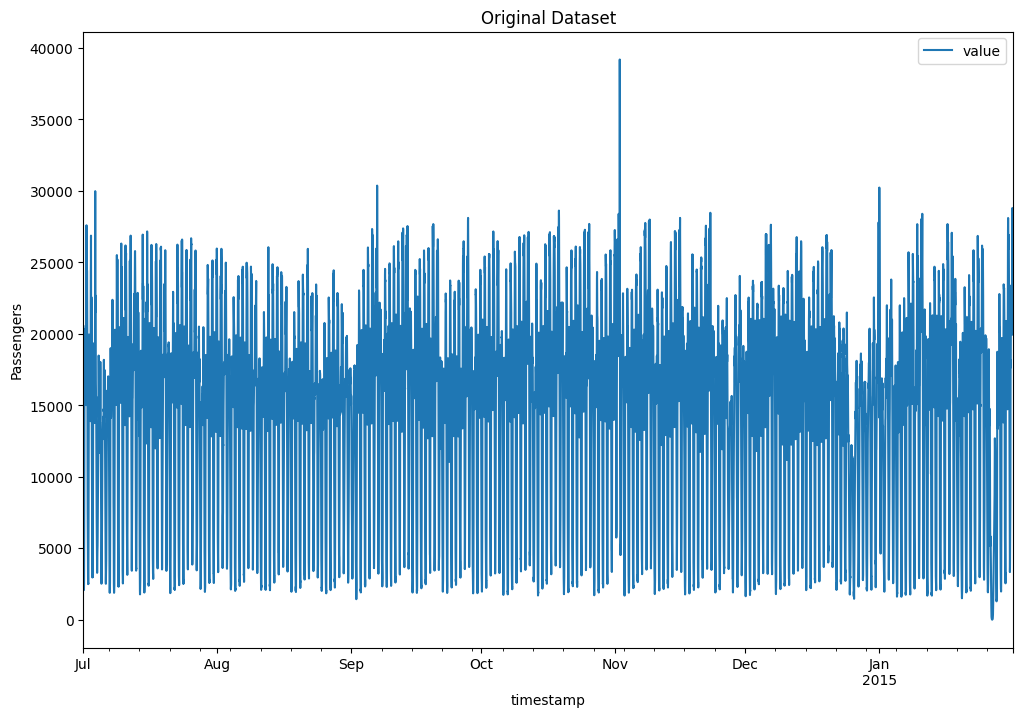

In [43]:
data = raw_dt.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.plot(x='timestamp', y='value', figsize=(12, 8))
plt.ylabel("Passengers")
plt.title("Original Dataset")

In [44]:
data['label'] = 0
with open('lists.pkl', 'rb') as f:
    lists = pickle.load(f)

# Access the lists
instances= lists[2]

In [45]:
for i in range(len(instances)): 
    start = pd.to_datetime(instances[i][0])
    end = pd.to_datetime(instances[i][1])
    data.loc[(data['timestamp'] >= start) & (data['timestamp'] <= end), 'label'] = 1

In [46]:
data_w_ts=data.copy()
data_w_ts

,timestamp,value,label
0,2014-07-01 00:00:00,10844,0
1,2014-07-01 00:30:00,8127,0
2,2014-07-01 01:00:00,6210,0
3,2014-07-01 01:30:00,4656,0
4,2014-07-01 02:00:00,3820,0
...,...,...,...
10315,2015-01-31 21:30:00,24670,0
10316,2015-01-31 22:00:00,25721,0
10317,2015-01-31 22:30:00,27309,0
10318,2015-01-31 23:00:00,26591,0


In [47]:
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data['hour_min'] = data['timestamp'].dt.hour + data['timestamp'].dt.minute / 60

data['day_of_week'] = data['timestamp'].dt.dayofweek
data.head()

,timestamp,value,label,day,month,hour_min,day_of_week
0,2014-07-01 00:00:00,10844,0,1,7,0.0,1
1,2014-07-01 00:30:00,8127,0,1,7,0.5,1
2,2014-07-01 01:00:00,6210,0,1,7,1.0,1
3,2014-07-01 01:30:00,4656,0,1,7,1.5,1
4,2014-07-01 02:00:00,3820,0,1,7,2.0,1


In [48]:
cont_vars = ['value', 'hour_min']
cat_vars = ['day', 'month', 'day_of_week']
data.drop('timestamp', axis=1, inplace=True)

In [49]:
from sklearn.preprocessing import LabelEncoder

label_encoders = [LabelEncoder() for _ in cat_vars] 
for col, enc in zip(cat_vars, label_encoders):
    data[col] = enc.fit_transform(data[col])
    
data= pd.get_dummies(data.iloc[:,:], columns= cat_vars )
data

,value,label,hour_min,day_0,day_1,day_2,day_3,day_4,day_5,day_6,...,month_4,month_5,month_6,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,10844,0,0.0,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,8127,0,0.5,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,6210,0,1.0,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,4656,0,1.5,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,3820,0,2.0,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10315,24670,0,21.5,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
10316,25721,0,22.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
10317,27309,0,22.5,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
10318,26591,0,23.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [50]:
print(data.keys())

Index(['value', 'label', 'hour_min', 'day_0', 'day_1', 'day_2', 'day_3',
       'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10',
       'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17',
       'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24',
       'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'month_0',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6'],
      dtype='object')


In [51]:
# Splitting to train and test
test_ratio = 0.5
start = 0       # or int(len(data) * 0.25 )  # or 0 
tr_data = data.iloc[start: int(len(data) * (1 - test_ratio))]
tst_data = data.iloc[int(len(data) * (1 - test_ratio)) :]

In [52]:
scaler = preprocessing.StandardScaler().fit(tr_data[cont_vars])

In [53]:
tr_data_scaled = tr_data.copy()
tr_data_scaled[cont_vars] = scaler.transform(tr_data[cont_vars])
tst_data_scaled = tst_data.copy()
tst_data_scaled[cont_vars] = scaler.transform(tst_data[cont_vars])

In [54]:
tr_data_scaled

,value,label,hour_min,day_0,day_1,day_2,day_3,day_4,day_5,day_6,...,month_4,month_5,month_6,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,-0.639517,0,-1.692319,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,-1.042645,0,-1.620134,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,-1.327074,0,-1.547949,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,-1.557645,0,-1.475764,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,-1.681684,0,-1.403579,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5155,0.786045,0,-0.320804,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
5156,0.671205,0,-0.248619,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
5157,0.541082,0,-0.176434,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
5158,0.306950,0,-0.104249,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False


In [55]:
tst_data_scaled

,value,label,hour_min,day_0,day_1,day_2,day_3,day_4,day_5,day_6,...,month_4,month_5,month_6,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
5160,0.376389,0,0.040121,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
5161,0.281579,0,0.112306,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
5162,0.241667,0,0.184492,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
5163,0.480398,0,0.256677,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
5164,0.510221,0,0.328862,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10315,1.411879,0,1.411637,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
10316,1.567819,0,1.483822,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
10317,1.803434,0,1.556007,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
10318,1.696903,0,1.628192,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [56]:
train = tr_data_scaled[tr_data_scaled.label != 1]
train= train.drop(columns=['label'])
train

,value,hour_min,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,...,month_4,month_5,month_6,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,-0.639517,-1.692319,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,-1.042645,-1.620134,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,-1.327074,-1.547949,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,-1.557645,-1.475764,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,-1.681684,-1.403579,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5155,0.786045,-0.320804,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
5156,0.671205,-0.248619,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
5157,0.541082,-0.176434,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
5158,0.306950,-0.104249,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False


In [57]:
labels_of_test = tst_data_scaled['label'].tolist()
test= tst_data_scaled.drop(columns=['label'])

In [58]:
#Converting df to arrays
train= train.to_numpy()
train= np.asarray(train).astype(np.float32)
test= test.to_numpy()
test= np.asarray(test).astype(np.float32)

In [59]:
vae_model = vae_model(train)
vae_model.summary()
# Finally, we train the model:
results = vae_model.fit(train,train, 
                        shuffle=True,
                        epochs=1000,
                        batch_size=32,
                        validation_split=0.1,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])


Model: "vae_mlp"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 47)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 15)        │      1,824 │ encoder_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 23)        │      1,104 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 47)        │      1,496 │ encoder[0][0]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 15)        │        360 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 15)        │        360 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer_1    │ (None, 47)        │          0 │ encoder_input[0]… │
│ (VAELossLayer)      │                   │            │ decoder[0][0],    │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,320 (12.97 KB)

 Trainable params: 3,320 (12.97 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000


146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 473.2693 - val_loss: 422.3734
Epoch 2/1000
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 429.3920 - val_loss: 384.1130
Epoch 3/1000
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 387.6111 - val_loss: 348.1207
Epoch 4/1000
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 350.8766 - val_loss: 311.9119
Epoch 5/1000
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 305.1263 - val_loss: 270.5487
Epoch 6/1000
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 258.8391 - val_loss: 232.7641
Epoch 7/1000
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 217.5516 - val_loss: 202.9265
Epoch 8/1000
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 186.0184 - val_loss: 179.6868
Epoch 9/1000
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 167.0141 - val_loss: 169.2049
Epoch 10/1000
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 153.9443 - val_loss: 165.4063
Epoch 11/1000
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 150.2297 - val_loss: 162.7643

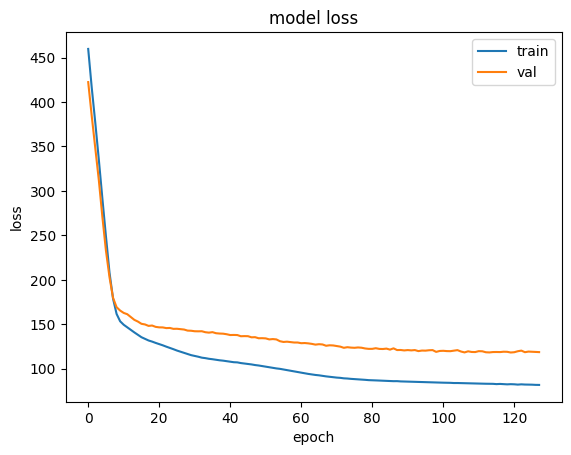

In [60]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [61]:
train_pred = vae_model.predict(train)[0]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [62]:
mae_vector = get_error_term(train_pred, train, _rmse=True)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}')
error_thresh = np.max(mae_vector)
print(f'setting threshold on {error_thresh} ')

Avg error 0.2122872769832611
median error 0.17668528854846954
setting threshold on 0.42942988872528076 


(array([  5.,   8.,  17.,  32.,  66., 181., 287., 443., 531., 415., 362.,
        281., 215., 152.,  96., 104.,  49.,  56.,  52.,  58.,  81.,  69.,
         73.,  64.,  83.,  64.,  66.,  83.,  59.,  85.,  85.,  95.,  99.,
         96.,  73.,  74.,  85., 103.,  86.,  70.,  57.,  21.,  22.,  14.,
          8.,  10.,  10.,   7.,   6.,   2.]),
 array([0.09821957, 0.10484377, 0.11146798, 0.11809219, 0.12471639,
        0.13134059, 0.1379648 , 0.14458901, 0.15121321, 0.15783742,
        0.16446163, 0.17108583, 0.17771004, 0.18433425, 0.19095846,
        0.19758266, 0.20420687, 0.21083108, 0.21745528, 0.22407949,
        0.2307037 , 0.2373279 , 0.24395211, 0.25057632, 0.25720051,
        0.26382473, 0.27044892, 0.27707314, 0.28369734, 0.29032156,
        0.29694575, 0.30356997, 0.31019416, 0.31681839, 0.32344258,
        0.3300668 , 0.33669099, 0.34331521, 0.34993941, 0.35656363,
        0.36318782, 0.36981204, 0.37643623, 0.38306046, 0.38968465,
        0.39630887, 0.40293306, 0.40955728, 0.

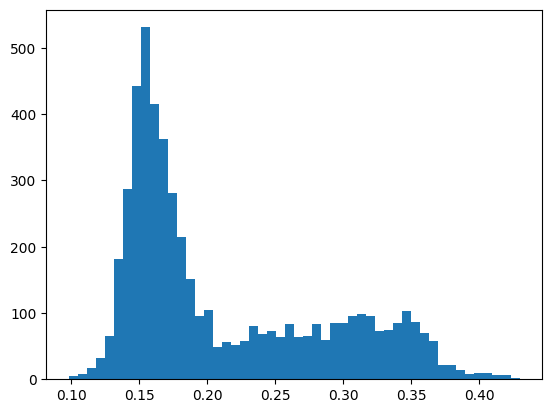

In [63]:
plt.hist(mae_vector, bins=50)

In [64]:
#Actual ratio of anomalies 
ratio=np.count_nonzero(labels_of_test) / len(labels_of_test)
print(ratio)

0.2005813953488372


In [65]:
pred = vae_model.predict(test)[0]
mae_vector_test = get_error_term(pred, test, _rmse=True)
print(f'Avg error {np.mean(mae_vector_test)}\nmedian error {np.median(mae_vector_test)}')
anomalies = (mae_vector_test > (error_thresh))

np.count_nonzero(anomalies) / len(anomalies)

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
Avg error 0.2841185927391052
median error 0.26287978887557983


0.00562015503875969

(array([  9.,  18.,  26.,  33.,  43.,  58.,  71., 208., 351., 438., 453.,
        500., 481., 359., 224., 144., 125., 107., 100.,  90., 112., 115.,
        113., 110., 119., 116., 138., 138., 134., 101.,  67.,  30.,  15.,
          6.,   2.,   3.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.15258485, 0.16125126, 0.16991767, 0.17858408, 0.18725049,
        0.19591691, 0.20458332, 0.21324973, 0.22191614, 0.23058255,
        0.23924896, 0.24791537, 0.25658178, 0.26524818, 0.27391461,
        0.282581  , 0.29124743, 0.29991382, 0.30858025, 0.31724665,
        0.32591307, 0.33457947, 0.34324589, 0.35191229, 0.36057872,
        0.36924511, 0.37791151, 0.38657793, 0.39524433, 0.40391076,
        0.41257715, 0.42124358, 0.42990997, 0.4385764 , 0.4472428 ,
        0.45590922, 0.46457562, 0.47324204, 0.48190844, 0.49057487,
        0.49924126, 0.50790769, 0.51657408, 0.52524048, 0.53390694,
        0.54257333, 0.55123973, 0.55990613, 0.

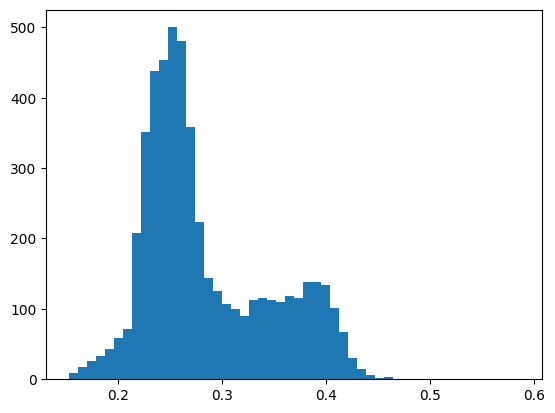

In [66]:
plt.hist(mae_vector_test, bins=50)

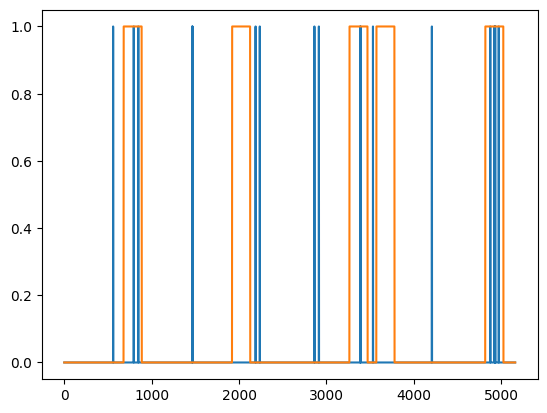

In [67]:
plt.plot(anomalies)
plt.plot(labels_of_test)

In [68]:
from sklearn.metrics import classification_report
# y_test contains the labels of anomaly =1
print(classification_report(np.logical_not(labels_of_test), anomalies))

              precision    recall  f1-score   support

       False       0.20      0.98      0.33      1035
        True       0.38      0.00      0.01      4125

    accuracy                           0.20      5160
   macro avg       0.29      0.49      0.17      5160
weighted avg       0.34      0.20      0.07      5160



In [69]:
tst_data['anomaly']=anomalies
df = data_w_ts['timestamp']
ts = df.iloc[int(len(data_w_ts) * (1 - test_ratio)) :]
tst_data['timestamp']=ts
tst_data = tst_data[['timestamp','value', 'label','anomaly']]

C:\Users\99anj\AppData\Local\Temp\ipykernel_6916\3776165707.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tst_data['anomaly']=anomalies
C:\Users\99anj\AppData\Local\Temp\ipykernel_6916\3776165707.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tst_data['timestamp']=ts


Text(0.5, 1.0, 'Location of the Anomalies on the Time Series, Test Period')

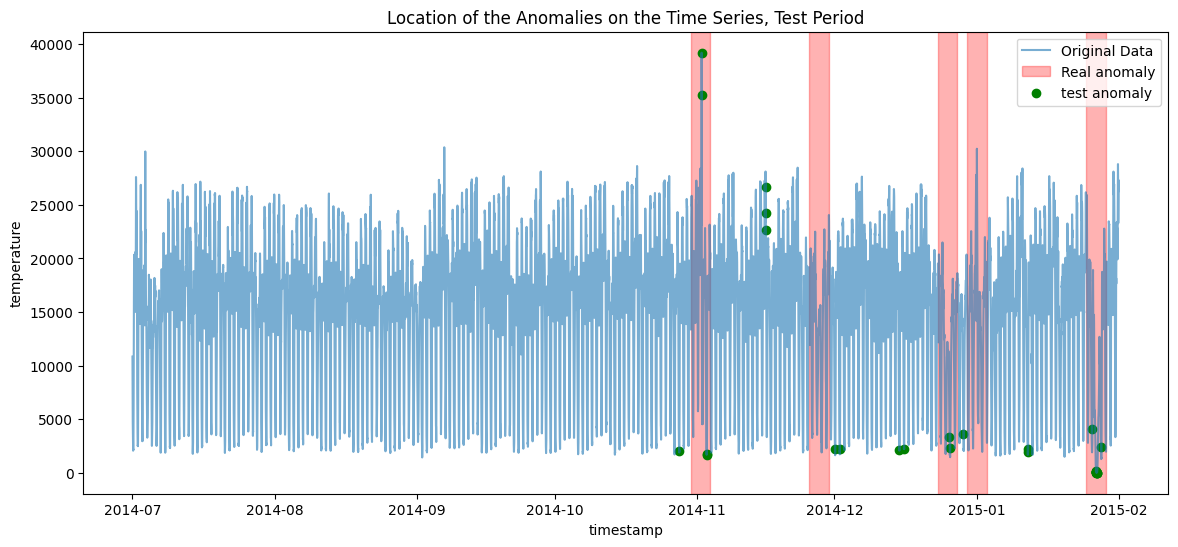

In [70]:
anomalies_ts = data_w_ts.loc[data_w_ts['label']==1, ('timestamp', 'value')]
testing = tst_data.loc[tst_data['anomaly']==True, ('timestamp', 'value')]
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data_w_ts['timestamp'], data_w_ts['value'], label='Original Data', alpha=0.6)
ax.fill_between(data_w_ts['timestamp'], 0, 1, where=data_w_ts['label'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(),label='Real anomaly')
#ax.scatter(anomalies_ts['timestamp'], anomalies_ts['value'], color='red', label='Real anomaly')
ax.scatter(testing['timestamp'], testing['value'], color='green', label='test anomaly')
plt.legend()
plt.xlabel("timestamp")
plt.ylabel("temperature")
plt.title("Location of the Anomalies on the Time Series, Test Period")